In [326]:
# Packages and adjustments to the figures
from scipy import signal
import matplotlib.pyplot as plt
#plt.rcParams.update(plt.rcParamsDefault)
import numpy as np
#plt.rcParams["figure.figsize"] = 10,5
#plt.rcParams["font.size"] = 12
#plt.rcParams.update({"text.usetex": True,"font.family": "sans-serif","font.sans-serif": ["Helvetica"]})


https://www.dafx.de/paper-archive/2013/papers/06.dafx2013_submission_46.pdf

https://www.isprs.org/PROCEEDINGS/XXV/congress/part7/163_XXV-part7.pdf

Moving median is a complex non linear filter

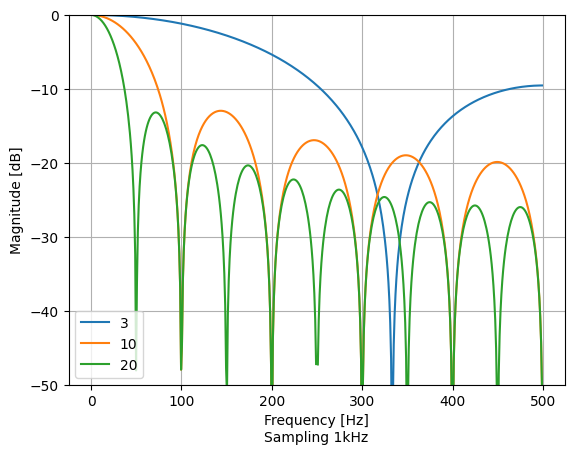

In [327]:
import warnings
warnings.filterwarnings('ignore')

fs = 1000  # Hz
w = np.linspace(0, np.pi, 1024)
fig, ax = plt.subplots()
for samples in [3, 10, 20]:
    # numerator co-effs of filter transfer function
    b = (np.ones(samples))/samples
    a = np.ones(1)  # denominator co-effs of filter transfer function
    w, h = signal.freqz(b, a)
    f = w * fs / (2*np.pi)
    ax.plot(f, 20 * np.log10(abs(h)), label="" + str(samples))


plt.ylabel('Magnitude [dB]')
plt.xlabel('Frequency [Hz]\nSampling 1kHz')
plt.grid(True)
plt.ylim(-50, 0)
plt.legend()
plt.show()


# IIR

IIR filter below, lookback of 1. Where n is a weigh for previous output

$Y_i = \frac{1}{k}*X_i + \frac{k-1}{k}*Y_{i-1}$

See https://www.electronicdesign.com/technologies/analog/article/21778422/use-software-filters-to-reduce-adc-noise

To analyze we translate the linear recurrence above into the canonical IIR form

$a_0y_n = \sum_{i=0}^{M}b_ix_{n-i} - \sum_{i=1}^{N}a_iy_{n-i}$

Where transfer function $H(z)$ is

$H(z)=\frac{b_0+b_1z^{-1}+\dots+b_Mz^{-M}}{a_0+a_1z^{-1}+\dots+a_Nz^{-N}}$

Original linear recurrence:

$1*y_n = \frac{1}{k}*x_i + \frac{k-1}{k}*y_{n-1}$

$1*y_n = \sum_{i=0}^{0}\frac{1}{n}*x_{n-0} - \sum_{i=1}^{1}a_iy_{n-1}$

$a_0=1, M=0, b_0=\frac{1}{k}, a_1=-\frac{k-1}{k}, b_1=0$

In `scipy.signal` terms we need two array of coefficients $[a_0,a_1,\dots,a_N] and [b_0,b_1,\dots,b_M]$ 
for the transfer function $H(z)$. 

In our case it looks like this

$a=[1, -\frac{k-1}{k}]$

$b=[\frac{1}{k},0]$

If sampling frequency $f_s$ is 1kHz, Nyquist frequencies we capture is up to 500Hz. To filter out slowly changing DC biase in the 
signal it's safe to assume (sic! arbitrary decision) that it will not change faster than 10Hz, i.e. we want the output signal to 
reflect new value in ${\frac{1}{10}}$ sec

$k\eqslantless\frac{1kHz}{10Hz}$

$k\eqslantless100$

It's a low pass filter with really no pass band and ~-35db per decade attenuation. Also notice that it is indeed a non-linear IIR filter, when impulse goes from amplitude 1 to 0, the filter output never reaches zero in $\infin$ time

See more https://warrenweckesser.github.io/papers/weckesser-scipy-linear-filters.pdf

IIR filters are better to deal with noise for time-domain signals. A slowly changing DC biase is a time-domain signal.

# FIR

A simple moving average or moving median are examples of FIR filters. In `scipy.signal` terms we need two array of coefficients $[a_0,a_1,\dots,a_N]$ for the input signal and $[b_0,b_1,\dots,b_M]=[1,\dots,1]$ for output for the transfer function $H(z)$. 

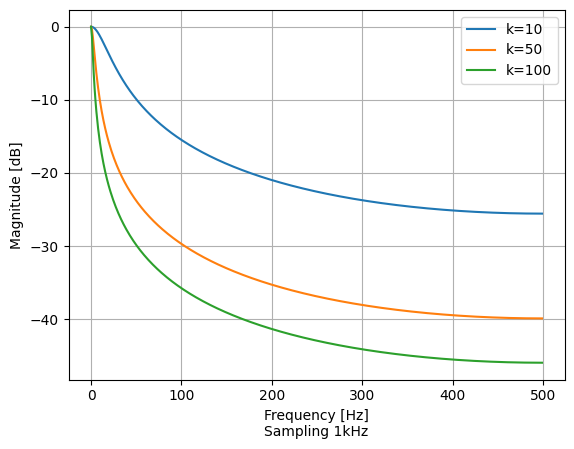

In [328]:
fs = 1000  # Hz
k = 100
w = np.linspace(0, np.pi, 1024)

fig, ax = plt.subplots()
for k in [10, 50, 100]:
    b = [1/k, 0] # numerator co-effs of filter transfer function
    a = [1, -(k-1)/k]  # denominator co-effs of filter transfer function
    w, h = signal.freqz(b, a)
    f = w * fs / (2*np.pi)
    ax.plot(f, 20 * np.log10(abs(h)), label="k=" + str(k))
plt.ylabel('Magnitude [dB]')
plt.xlabel('Frequency [Hz]\nSampling 1kHz')
plt.grid(True)
#plt.xlim(0, 100)
# plt.ylim(-50, 0)
plt.legend()
plt.show()

In [329]:
def ma(x, n=5):
    b = np.repeat(1.0/n, n)  # Create impulse response
    xf = signal.lfilter(b, 1, x)  # Filter the signal
    return xf

def binomcoeffs(n):
    return (np.poly1d([0.5, 0.5])**n).coeffs


# This is IIR filter, all others here are FIRs
# Theory https://brianmcfee.net/dstbook-site/content/ch11-iir/IIRFilters.html
# https://warrenweckesser.github.io/papers/weckesser-scipy-linear-filters.pd
# This is is rather computationally simple https://www.electronicdesign.com/technologies/analog/article/21778422/use-software-filters-to-reduce-adc-noise

def feedback(x, n=5): 
    result=[] 
    y_prev = 0;
    for item in x:
        y_prev = 1.0/n*item+(n-1)/n*y_prev
        result.append(y_prev)
        
    return (result);

def iir(x, n=5):
    b = [1/n, 0]
    a = [1, -(n-1)/n]
    zi = signal.lfiltic(b, a, y=[0])
    y, z0 = signal.lfilter(b, a, x, zi=zi)
    return y

def plotResponses(noisy):
    yBinomial11 = np.convolve(noisy, binomcoeffs(11), mode='valid')
    yBinomial31 = np.convolve(noisy, binomcoeffs(31), mode='valid')
    yFeedback = feedback(noisy, 31);
    yIIR = iir(noisy, 100);
    # Moving average filters
    ym11 = ma(noisy, 11)
    ym31 = ma(noisy, 31)
    # Median filter from scipy.signal
    ymed11 = signal.medfilt(noisy, 11)
    ymed31 = signal.medfilt(noisy, 31)
 
    f = plt.figure()
    ax1 = plt.subplot2grid((5,2),(0, 0))
    ax1.plot(noisy)
    ax1.set_title("a) Noisy signal")

    ax2 = plt.subplot2grid((5,2),(0, 1), sharex=ax1, sharey=ax1)
    ax2.plot(ym11)
    ax2.set_title("b) Moving average filter n = 11")

    ax3 = plt.subplot2grid((5,2),(1, 0), sharex=ax1, sharey=ax1)
    ax3.plot(ym31)
    ax3.set_title("c) Moving average filter n = 31")
    
    ax4 = plt.subplot2grid((5,2),(1, 1), sharex=ax1, sharey=ax1)
    ax4.plot(ymed11)
    ax4.set_title("d) Median filter n = 11")
    
    ax5 = plt.subplot2grid((5,2),(2, 0), sharex=ax1, sharey=ax1)
    ax5.plot(ymed31)
    ax5.set_title("e) Median filter n = 31")
 
    ax6 = plt.subplot2grid((5,2),(2, 1), sharex=ax1, sharey=ax1)
    ax6.plot(yBinomial11)
    ax6.set_title("f) Binomial 11")
    
    ax7 = plt.subplot2grid((5,2),(3, 0), sharex=ax1, sharey=ax1)
    ax7.plot(yBinomial31)
    ax7.set_title("g) Binomial 31")
    
    ax8 = plt.subplot2grid((5,2),(3, 1), sharex=ax1, sharey=ax1)
    ax8.plot(yFeedback)
    ax8.set_title("j) diy IIR filter 1/31 weight")
    
    ax9 = plt.subplot2grid((5,2),(4, 0), sharex=ax1, sharey=ax1)
    ax9.plot(yIIR)
    ax9.set_title("k) IIR filter 1/31 weight")
    
    plt.subplots_adjust(hspace=0.5)
    for ax in f.axes:
        ax.grid()
    f.set_size_inches(12, 15)
    plt.show()


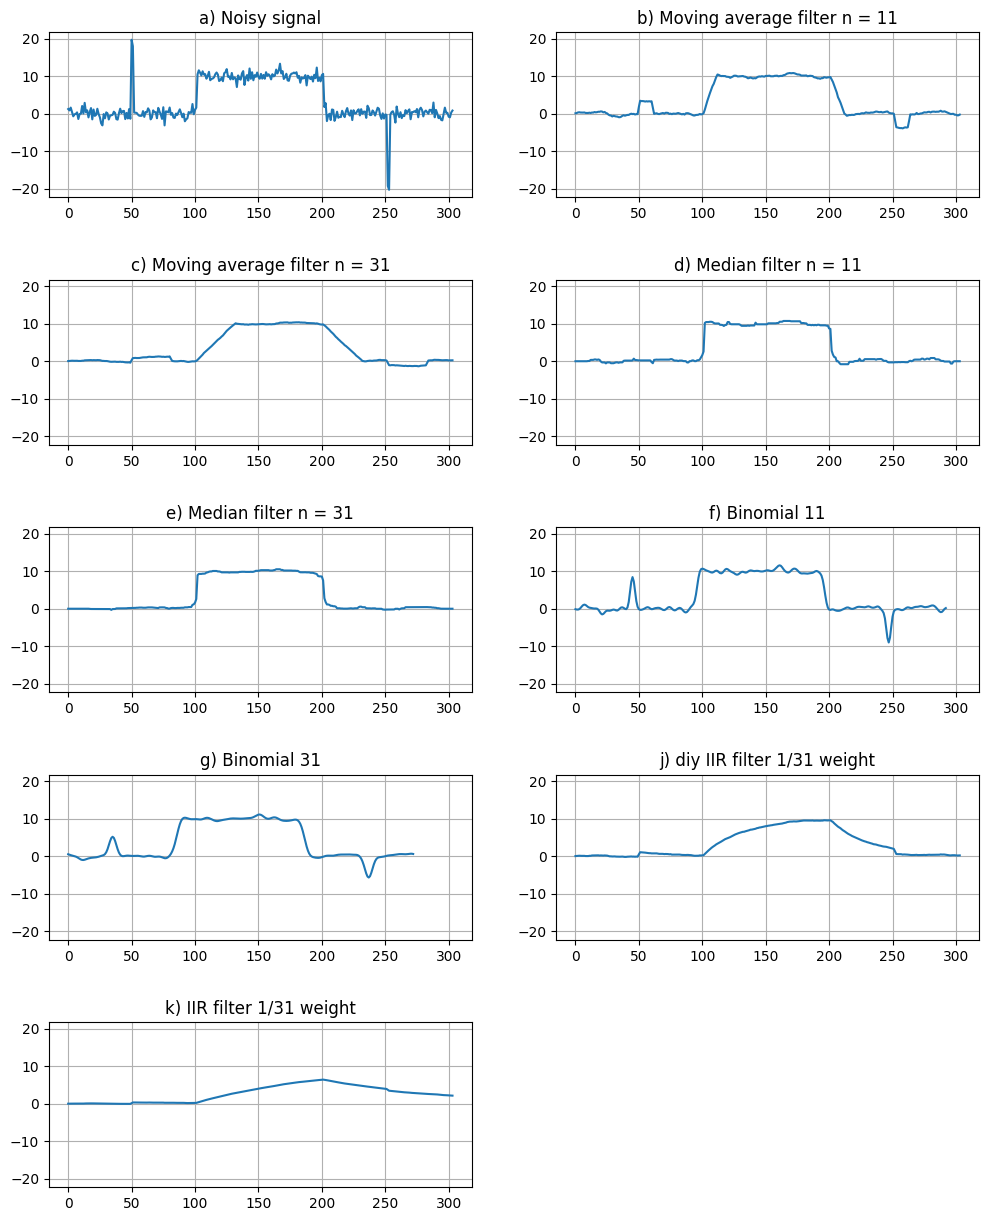

In [330]:
# simple random noise
ym = np.hstack([np.repeat(0, 50), np.repeat(20, 2), np.repeat(0, 50), np.repeat(
    10, 100), np.repeat(0, 50), np.repeat(-20, 2), np.repeat(0, 50)])
noisy = ym+np.random.randn(304)
plotResponses(noisy)


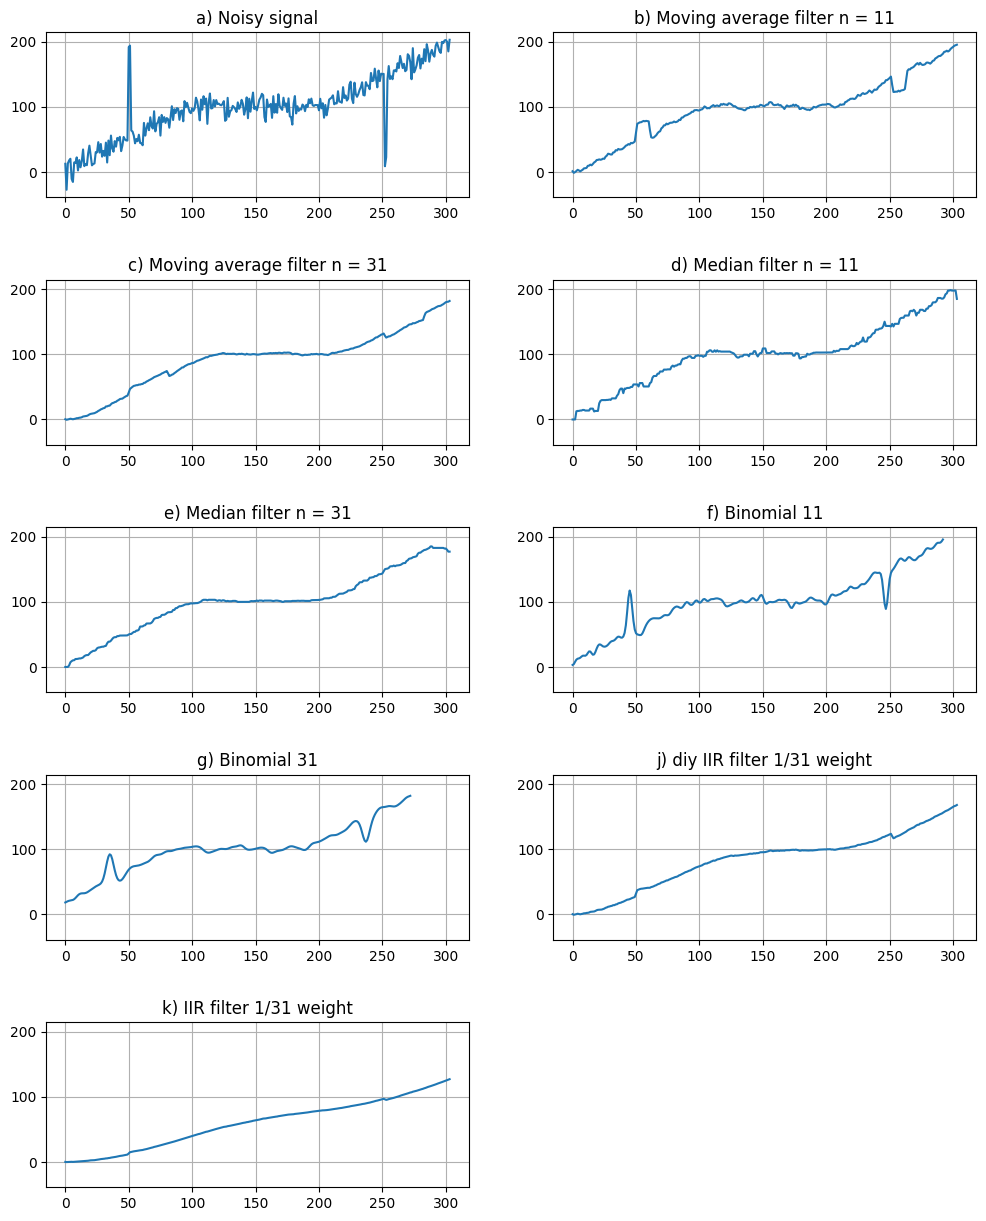

In [331]:
# simple random noise with spikes
ym = np.hstack([np.arange(0, 50), np.repeat(200, 2), np.arange(50, 100), np.repeat(
    100, 100), np.arange(100, 150), np.repeat(20, 2), np.arange(150, 200)])
noisy = ym+np.random.randn(304)*10
plotResponses(noisy)


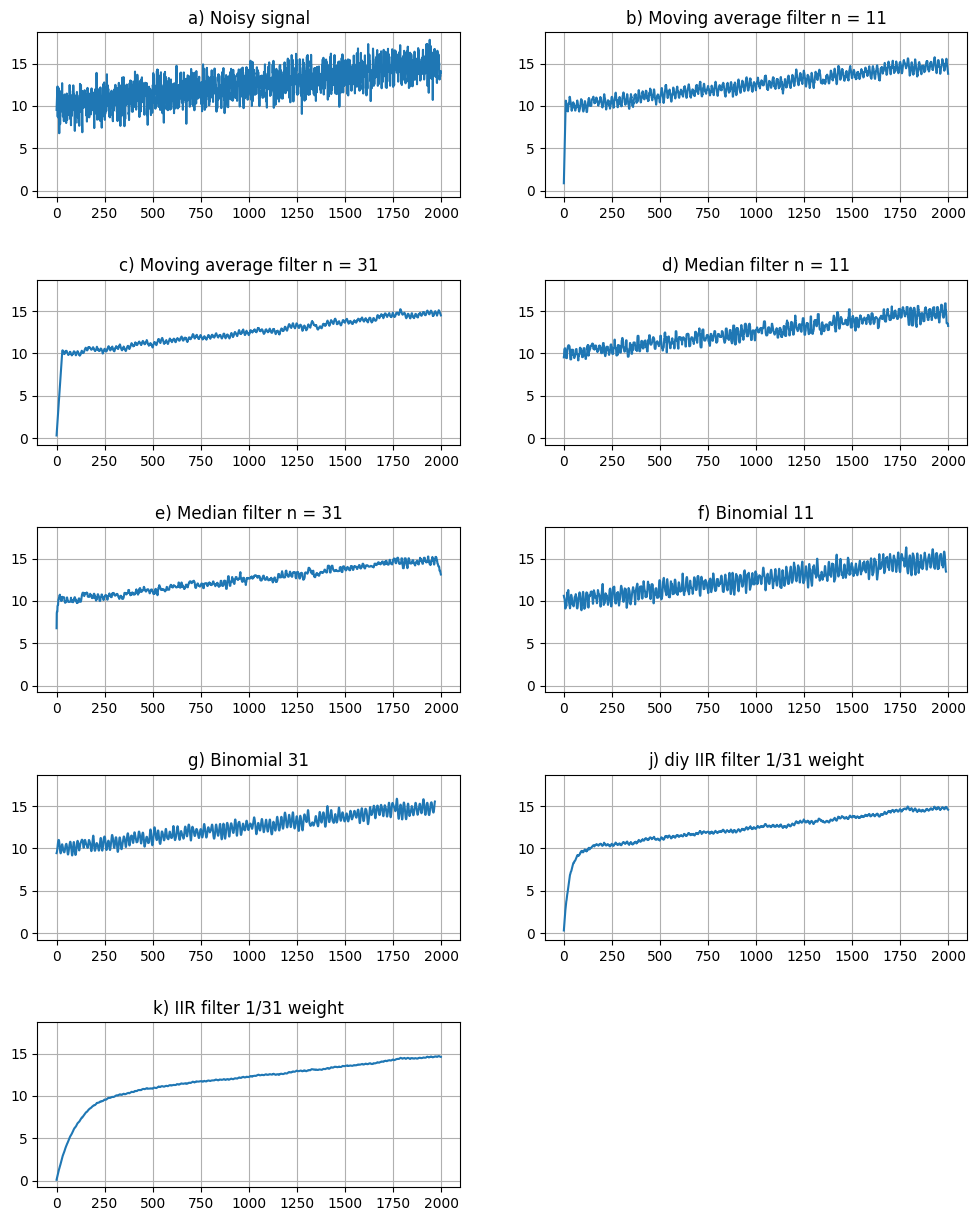

In [332]:
# complex noise 50Hz hum super imposed with random noise

samplingFreq = 1000
dcBias = np.linspace(10, 15, 2*samplingFreq)
tlims = [0, 2]        # in seconds
signalFreq = [50, 150]  # Cycles / second
signalMag = [1, 0.3]  # magnitude of each sine
t = np.linspace(tlims[0], tlims[1], (tlims[1]-tlims[0])*samplingFreq)
y = np.random.randn(t.size)
y = dcBias + (np.random.randn(t.size)) + signalMag[0]*np.sin(
    2*np.pi*signalFreq[0]*t) + signalMag[1]*np.sin(2*np.pi*signalFreq[1]*t)

plotResponses(y)

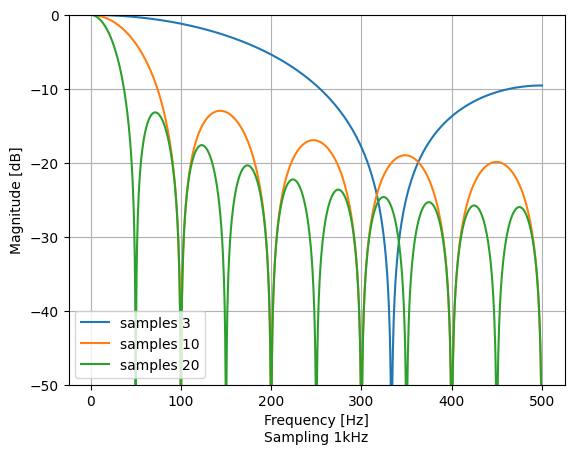

In [333]:
# Moving avergae filters
fs = 1000  # Hz
w = np.linspace(0, np.pi, 1024)

fig, ax = plt.subplots()
for samples in [3, 10, 20]:
    f = w * fs / (2*np.pi)
    H = (1/samples)*(1-np.exp(-1j*w*samples))/(1-np.exp(-1j*w))
    ax.plot(f, 20 * np.log10(abs(H)), label="samples " + str(samples))

plt.ylabel('Magnitude [dB]')
plt.xlabel('Frequency [Hz]\nSampling 1kHz')
plt.grid(True)
plt.legend()
plt.ylim(-50, 0)
plt.show()


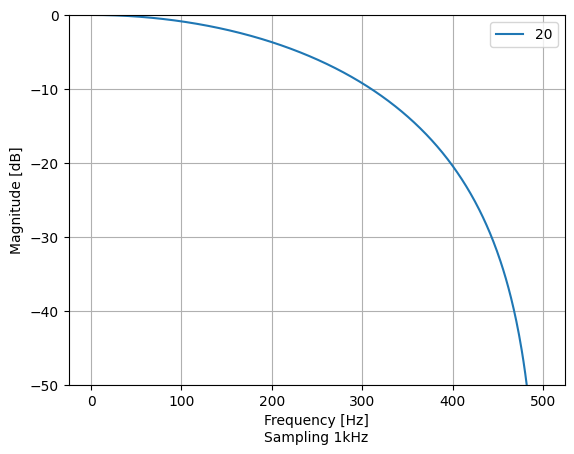

In [334]:
# simple binomial filter 
fs = 1000  # Hz
w = np.linspace(0, np.pi, 1024)
fig, ax = plt.subplots()
# numerator co-effs of filter transfer function
filt = np.array([0.25, 0.5, 0.25])
a = np.ones(1)  # denominator co-effs of filter transfer function
w, h = signal.freqz(filt, a)
f = w * fs / (2*np.pi)
ax.plot(f, 20 * np.log10(abs(h)), label="" + str(samples))


plt.ylabel('Magnitude [dB]')
plt.xlabel('Frequency [Hz]\nSampling 1kHz')
plt.grid(True)
plt.ylim(-50, 0)
plt.legend()
plt.show()
